<a href="https://colab.research.google.com/github/ErMarP/Redes-Neuronales/blob/main/Practica01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

run 1/10 | act=relu | test acc=0.6481
run 2/10 | act=relu | test acc=0.5926
run 3/10 | act=relu | test acc=0.6741
run 4/10 | act=relu | test acc=0.6630
run 5/10 | act=relu | test acc=0.7037
run 6/10 | act=relu | test acc=0.6333
run 7/10 | act=relu | test acc=0.6593
run 8/10 | act=relu | test acc=0.6926
run 9/10 | act=relu | test acc=0.7037
run 10/10 | act=relu | test acc=0.6741
== relu -> mean acc: 0.6644 ± 0.0324
run 1/10 | act=sigmoid | test acc=0.5407
run 2/10 | act=sigmoid | test acc=0.6630
run 3/10 | act=sigmoid | test acc=0.6556
run 4/10 | act=sigmoid | test acc=0.5222
run 5/10 | act=sigmoid | test acc=0.5667
run 6/10 | act=sigmoid | test acc=0.5778
run 7/10 | act=sigmoid | test acc=0.5630
run 8/10 | act=sigmoid | test acc=0.7074
run 9/10 | act=sigmoid | test acc=0.6333
run 10/10 | act=sigmoid | test acc=0.6926
== sigmoid -> mean acc: 0.6122 ± 0.0627


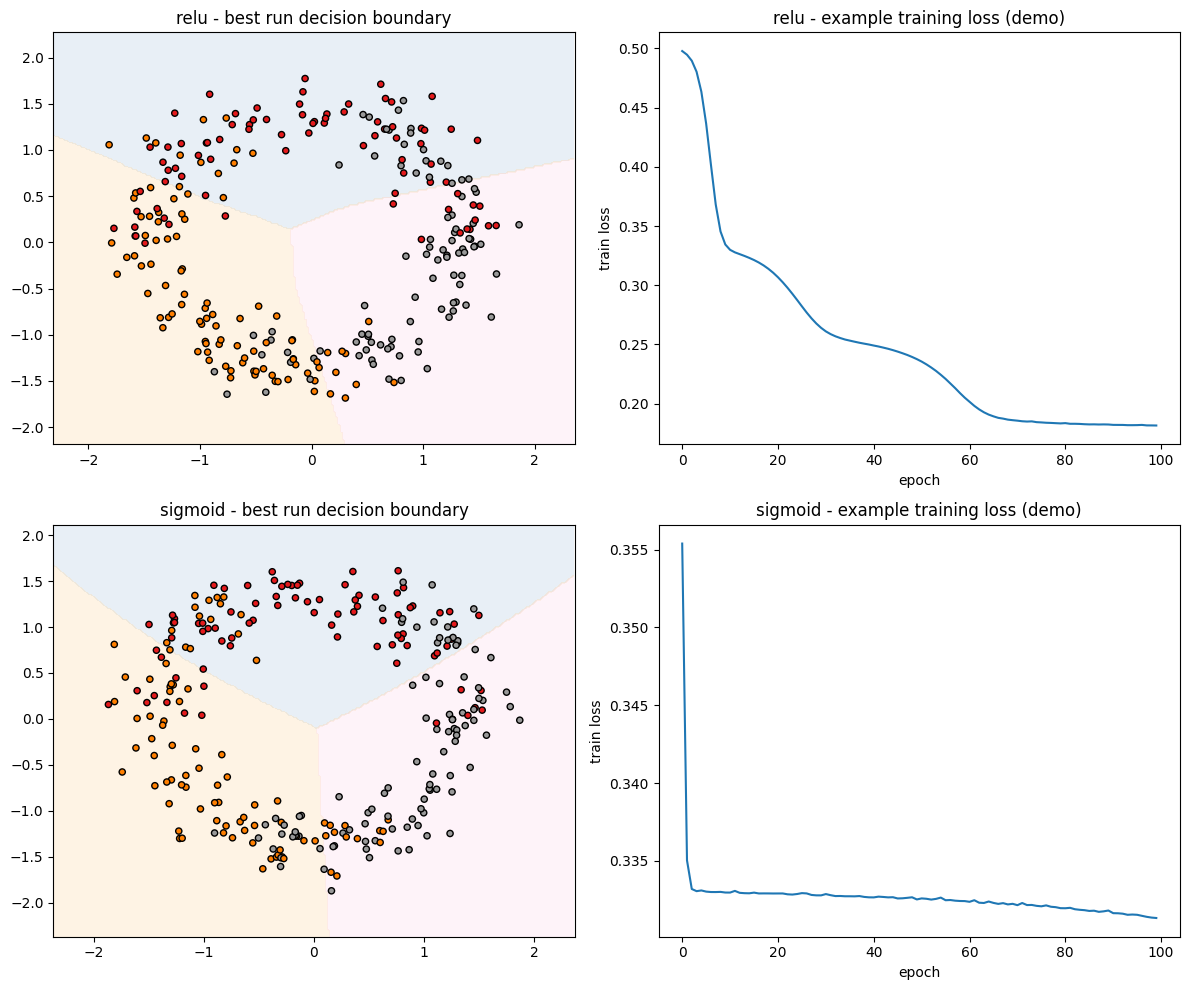


Summary of results:
relu: mean acc = 0.6644, std = 0.0324
sigmoid: mean acc = 0.6122, std = 0.0627


In [4]:
# mlp_moons.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# -----------------------
# Datos: "Three moons" generator
# -----------------------
def generate_three_moons(n_samples=900, noise=0.1, random_state=None):
    """
    Genera ~3 clases tipo "moons" (tres medias lunas rotadas).
    Devuelve X (n,2), y (n,) con etiquetas 0,1,2.
    """
    rng = np.random.RandomState(random_state)
    per_moon = n_samples // 3
    X_list, y_list = [], []

    # cada "moon" es un semicírculo (theta en [0, pi])
    for i, angle_offset in enumerate([0.0, 2*np.pi/3, 4*np.pi/3]):
        theta = rng.rand(per_moon) * np.pi
        r = 1.0 + 0.1 * rng.randn(per_moon)  # radio con pequeña variación
        x = r * np.cos(theta + angle_offset)
        y = r * np.sin(theta + angle_offset)
        pts = np.stack([x, y], axis=1)
        pts += noise * rng.randn(*pts.shape)
        X_list.append(pts)
        y_list.append(np.full(per_moon, i, dtype=int))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    # si quedaron pocos por división, añadir aleatorios
    remaining = n_samples - X.shape[0]
    if remaining > 0:
        extra_X = 0.5 * rng.randn(remaining, 2)
        extra_y = rng.randint(0, 3, size=remaining)
        X = np.vstack([X, extra_X])
        y = np.concatenate([y, extra_y])
    # normalize roughly
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y

# -----------------------
# Activaciones y derivadas
# -----------------------
def sigmoid(z, k=1.0):
    return 1.0 / (1.0 + np.exp(-k*z))

def sigmoid_prime(z, k=1.0):
    s = sigmoid(z, k)
    return k * s * (1 - s)

def relu(z):
    return np.where(z > 0, z, 0.0)

def relu_prime(z):
    return (z > 0).astype(float)

# -----------------------
# MLP class (NumPy)
# -----------------------
class MLP_2_8_8_3:
    def __init__(self, activation='relu', k=1.0, seed=None):
        rng = np.random.RandomState(seed)
        # sizes
        self.n0 = 2
        self.n1 = 8
        self.n2 = 8
        self.n3 = 3

        # weights initialization (small random)
        self.W1 = rng.randn(self.n1, self.n0) * 0.1
        self.W2 = rng.randn(self.n2, self.n1) * 0.1
        self.W3 = rng.randn(self.n3, self.n2) * 0.1

        # biases only in hidden layers 1 and 2
        self.b1 = np.zeros((self.n1, 1))
        self.b2 = np.zeros((self.n2, 1))
        # note: no biases in output (as requested)

        # activation selection
        if activation == 'relu':
            self.f = relu
            self.f_prime = relu_prime
            self.k = 1.0
        elif activation == 'sigmoid':
            self.f = lambda z: sigmoid(z, k)
            self.f_prime = lambda z: sigmoid_prime(z, k)
            self.k = k
        else:
            raise ValueError("activation must be 'relu' or 'sigmoid'")

    def forward(self, X):
        """
        X shape: (n_samples, 2)
        returns: a1,h1,a2,h2,a3 (a3 = hat_y)
        shapes: a1 (n_samples, n1), h1 same, a2 (n_samples, n2), h2 same, a3 (n_samples,n3)
        """
        # column vectors internally: but we'll work batch-wise as row-major
        a1 = X.dot(self.W1.T) + self.b1.T  # (N, n1)
        h1 = self.f(a1)
        a2 = h1.dot(self.W2.T) + self.b2.T  # (N, n2)
        h2 = self.f(a2)
        a3 = h2.dot(self.W3.T)  # (N, n3)  # linear output
        return a1, h1, a2, h2, a3

    def predict(self, X):
        _, _, _, _, a3 = self.forward(X)
        # a3 are raw scores, choose argmax
        return np.argmax(a3, axis=1)

    def compute_loss_and_grads(self, X, Y_onehot):
        """
        One forward pass + compute MSE loss and gradients (per batch X)
        Y_onehot shape: (N, n3)
        Returns loss (scalar) and grads as dict (dW1,dW2,dW3, db1, db2)
        """
        N = X.shape[0]
        a1, h1, a2, h2, a3 = self.forward(X)
        # MSE: (1/2N) * sum ||y - hat_y||^2  -> but we'll use 1/2 sum (consistent with notes)
        # Here use average per pattern for stability: loss = (1/(2N)) sum ||y - a3||^2
        diff = a3 - Y_onehot  # (N,n3)
        loss = 0.5 * np.mean(np.sum(diff**2, axis=1))  # scalar

        # Backprop
        # delta3 = dL/da3 = (1/N) * (a3 - Y)   if we used mean; we'll keep consistent with loss above
        delta3 = diff / N  # (N,n3)

        # gradients for W3: dW3 = delta3^T dot h2  -> (n3,n2)
        dW3 = delta3.T.dot(h2)  # (n3, n2)

        # backprop to h2
        dh2 = delta3.dot(self.W3)  # (N, n2)
        da2 = dh2 * self.f_prime(a2)  # (N, n2)

        dW2 = da2.T.dot(h1)  # (n2, n1)
        db2 = np.sum(da2, axis=0, keepdims=True).T  # (n2,1)

        # backprop to h1
        dh1 = da2.dot(self.W2)  # (N, n1)
        da1 = dh1 * self.f_prime(a1)  # (N, n1)

        dW1 = da1.T.dot(X)  # (n1,n0)
        db1 = np.sum(da1, axis=0, keepdims=True).T  # (n1,1)

        grads = {
            'dW1': dW1,
            'dW2': dW2,
            'dW3': dW3,
            'db1': db1,
            'db2': db2
        }
        return loss, grads

    def update_params(self, grads, lr=1e-2):
        self.W1 -= lr * grads['dW1']
        self.W2 -= lr * grads['dW2']
        self.W3 -= lr * grads['dW3']
        self.b1 -= lr * grads['db1']
        self.b2 -= lr * grads['db2']

# -----------------------
# Training and evaluation helpers
# -----------------------
def one_hot(y, n_classes=3):
    oh = np.zeros((y.shape[0], n_classes))
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def train_model(X_train, y_train, X_val, y_val, activation='relu',
                epochs=200, batch_size=32, lr=0.01, seed=None):
    model = MLP_2_8_8_3(activation=activation, seed=seed)
    N = X_train.shape[0]
    Y_train_oh = one_hot(y_train, n_classes=3)
    Y_val_oh = one_hot(y_val, n_classes=3)

    history = {'loss': []}
    for epoch in range(epochs):
        # shuffle
        perm = np.random.permutation(N)
        X_sh = X_train[perm]
        Y_sh = Y_train_oh[perm]
        # minibatches
        for i in range(0, N, batch_size):
            xb = X_sh[i:i+batch_size]
            yb = Y_sh[i:i+batch_size]
            loss, grads = model.compute_loss_and_grads(xb, yb)
            model.update_params(grads, lr=lr)
        # compute epoch loss on train (optional)
        train_loss, _ = model.compute_loss_and_grads(X_train, Y_train_oh)
        history['loss'].append(train_loss)
    # final accuracies
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    return model, history, acc

# -----------------------
# Decision boundary plotting
# -----------------------
def plot_decision_boundary(model, X, y, title=None, ax=None, mesh_step=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min,x_max,mesh_step),
                         np.arange(y_min,y_max,mesh_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.5,0.5,1.5,2.5], cmap='Pastel1')
    scatter = ax.scatter(X[:,0], X[:,1], c=y, s=20, cmap='Set1', edgecolor='k')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    if title:
        ax.set_title(title)
    return ax

# -----------------------
# Main experiment: repeat runs and compare activations
# -----------------------
def run_experiment(n_runs=10, activation_list=('relu', 'sigmoid'), seed_base=0):
    results = {}
    for activation in activation_list:
        accs = []
        models = []
        for run in range(n_runs):
            seed = seed_base + run
            # generate data, split
            X, y = generate_three_moons(n_samples=900, noise=0.12, random_state=seed)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
            model, history, acc = train_model(X_train, y_train, X_test, y_test,
                                              activation=activation, epochs=300,
                                              batch_size=32, lr=0.03, seed=seed)
            accs.append(acc)
            models.append(model)
            print(f"run {run+1}/{n_runs} | act={activation} | test acc={acc:.4f}")
        results[activation] = {'accs': np.array(accs), 'models': models, 'mean_acc': np.mean(accs), 'std_acc': np.std(accs)}
        print(f"== {activation} -> mean acc: {results[activation]['mean_acc']:.4f} ± {results[activation]['std_acc']:.4f}")
    return results

# -----------------------
# If run as script: execute experiment and plot decision boundaries
# -----------------------
if __name__ == "__main__":
    np.random.seed(0)
    results = run_experiment(n_runs=10, activation_list=('relu','sigmoid'), seed_base=1)

    # choose best model (highest test acc) for each activation and plot decision boundary
    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    for i, activation in enumerate(['relu','sigmoid']):
        accs = results[activation]['accs']
        best_idx = np.argmax(accs)
        best_model = results[activation]['models'][best_idx]

        # regenerate a dataset to plot (same seed used in training best_idx)
        seed = 1 + best_idx
        X_all, y_all = generate_three_moons(n_samples=900, noise=0.12, random_state=seed)
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=seed)

        ax = axs[i,0]
        plot_decision_boundary(best_model, X_test, y_test, title=f"{activation} - best run decision boundary", ax=ax)

        # also plot one example run's loss curve
        # we have no per-epoch history saved in results for each run (only last), so retrain a short model to show typical loss:
        model_demo, history_demo, acc_demo = train_model(X_train, y_train, X_test, y_test,
                                                         activation=activation, epochs=100,
                                                         batch_size=32, lr=0.03, seed=42)
        ax2 = axs[i,1]
        ax2.plot(history_demo['loss'])
        ax2.set_title(f"{activation} - example training loss (demo)")
        ax2.set_xlabel("epoch")
        ax2.set_ylabel("train loss")

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\nSummary of results:")
    for activation in results:
        print(f"{activation}: mean acc = {results[activation]['mean_acc']:.4f}, std = {results[activation]['std_acc']:.4f}")